## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample 
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix



Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')


#Get patients <= 100 years old to remove what seems to be bad data.

all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]



all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
83801,00020593_000.png,Cardiomegaly|Effusion,0,20593,58,F,PA,2276,2280,0.143,0.143,NaN,/data/images_009/images/00020593_000.png
46998,00011982_000.png,Nodule,0,11982,68,M,PA,2822,2991,0.143,0.143,NaN,/data/images_006/images/00011982_000.png
39579,00010352_027.png,No Finding,27,10352,31,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010352_027.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)
                        


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
48076,00012176_002.png,No Finding,2,12176,34,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
74806,00018362_002.png,No Finding,2,18362,46,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
91140,00022725_000.png,No Finding,0,22725,3,F,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda finding: 'Pneumonia_Found' if finding ==1 else 'No_Pneumonia')

## Create your training and testing data:

In [5]:
def create_splits(data_set, test_size, stratify_field):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(data_set, 
                                   test_size = test_size, 
                                   stratify = data_set[stratify_field])
    #Need to balance the training dataset between pneumonia and no-pneumonia
    p_inds = train_data[train_data[stratify_field]=="Pneumonia_Found"].index.tolist()
    np_inds = train_data[train_data[stratify_field]=="No_Pneumonia"].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]

    p_inds = val_data[val_data[stratify_field]=="Pneumonia_Found"].index.tolist()
    np_inds = val_data[val_data[stratify_field]=="No_Pneumonia"].index.tolist()
    
    #Correct the validation No_Pneumonia to 4 times the Pneumonia cases in the wild.
    np_sample = sample(np_inds,len(p_inds) * 4)
    val_data = val_data.loc[p_inds + np_sample]
    
    return train_data, val_data


In [6]:
#Create train/val datasets
train_data_set, val_data_set = create_splits(all_xray_df, 0.2, 'pneumonia_class')

train_pneumonia_count  = train_data_set.query('pneumonia_class == "Pneumonia_Found"')['pneumonia_class'].count()
train_no_pneumonia_count = train_data_set.query('pneumonia_class == "No_Pneumonia"')['pneumonia_class'].count()

print("Train dataset has a total of {} records." .format(len(train_data_set)))
print("Train dataset has {} pneumonia cases which is {:.2%}." .format(train_pneumonia_count, train_pneumonia_count/len(train_data_set)))
print("Train dataset has {} no-pneumonia cases which is {:.2%}.\n" .format(train_no_pneumonia_count, train_no_pneumonia_count/len(train_data_set)))


val_pneumonia_count  = val_data_set.query('pneumonia_class == "Pneumonia_Found"')['pneumonia_class'].count()
val_no_pneumonia_count = val_data_set.query('pneumonia_class == "No_Pneumonia"')['pneumonia_class'].count()

print("Validation dataset has a total of {} records." .format(len(val_data_set)))
print("Validation dataset has {} pneumonia cases which is {:.2%}." .format(val_pneumonia_count, val_pneumonia_count/len(val_data_set)))
print("Validation dataset has {} no-pneumonia cases which is {:.2%}." .format(val_no_pneumonia_count, val_no_pneumonia_count/len(val_data_set)))



#print("Validation dataset has {} pneumonia cases which is {:.2%}." .format(valid_data_set['Pneumonia'].sum(), valid_data_set['Pneumonia'].sum()/len(valid_data_set)))
          


Train dataset has a total of 2288 records.
Train dataset has 1144 pneumonia cases which is 50.00%.
Train dataset has 1144 no-pneumonia cases which is 50.00%.

Validation dataset has a total of 1430 records.
Validation dataset has 286 pneumonia cases which is 20.00%.
Validation dataset has 1144 no-pneumonia cases which is 80.00%.


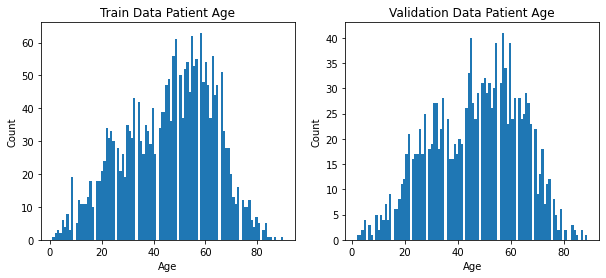

In [10]:
figure, (ax1,ax2) = plt.subplots(1,2, figsize = (10, 4))
ax1.hist(train_data_set['Patient Age'],bins=100)
ax1.set_ylabel("Count")
ax1.set_xlabel("Age")
ax1.set_title("Train Data Patient Age")
ax2.hist(val_data_set['Patient Age'],bins=100)
ax2.set_ylabel("Count")
ax2.set_xlabel("Age")
ax2.set_title("Validation Data Patient Age")
plt.show()

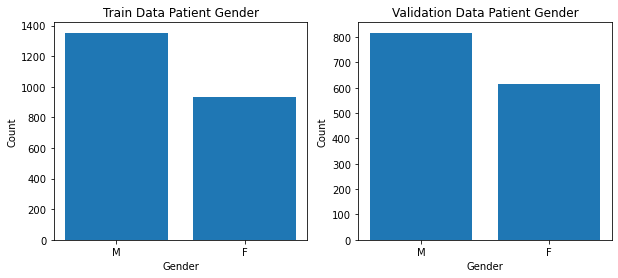

In [11]:
figure, (ax0,ax1) = plt.subplots(1,2, figsize = (10, 4))
train_gender_count=train_data_set['Patient Gender'].value_counts()
val_gender_count=val_data_set['Patient Gender'].value_counts()

ax0.bar(train_gender_count.index, train_gender_count)
ax0.set_title('Train Data Patient Gender')
ax0.set_xlabel('Gender')
ax0.set_ylabel('Count')

ax1.bar(val_gender_count.index, val_gender_count)
ax1.set_title('Validation Data Patient Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Count')

plt.show()

# Now we can begin our model-building & training


#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation(df):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
  
    
    idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    return idg


def make_train_gen(df,path_column, class_column,class_mode, image_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
  
    idg = my_image_augmentation(df)
    train_gen = idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = path_column,
                                         y_col = class_column,
                                         class_mode = class_mode,
                                         target_size = image_size, 
                                         batch_size = 32
                                         )
    return train_gen


def make_val_gen(df,path_column,class_column,class_mode, image_size):

    my_val_idg =  ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = df, 
                                             directory=None, 
                                             x_col = path_column ,
                                             y_col = class_column,
                                             class_mode = class_mode,
                                             target_size = image_size, 
                                             batch_size = 100) 

    return val_gen

In [8]:
IMG_SIZE = (224, 224)
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data_set,'path','pneumonia_class','binary', IMG_SIZE)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2288 validated image filenames belonging to 2 classes.


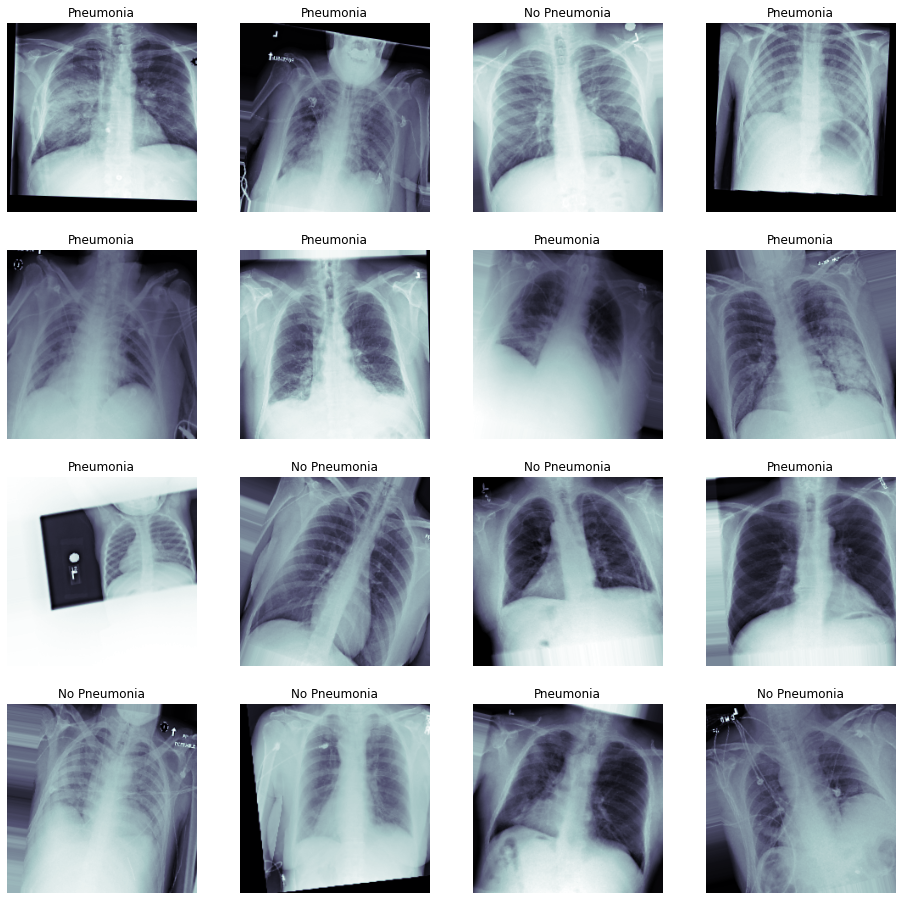

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_gen = make_train_gen(train_data_set,'path','pneumonia_class','binary', IMG_SIZE)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [50]:
   
def plot_roc_curve(t_y, p_y):
     ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    res = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia',res))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return fpr, tpr, thresholds, res


## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, thresholds

def plot_f1t(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1=2*(precision*recall)/(precision+recall)
    c_ax.plot( thresholds,f1[0:len(thresholds)], label = 'f1_score vs threshold')
    c_ax.legend()
    c_ax.set_xlabel('thresholds')
    c_ax.set_ylabel('f1_score')
    return f1

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

def plot_score_thresholds(precision, recall, f1_score, thresholds):
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label ='Recall')
    plt.plot(thresholds, f1_score, label = 'F1_Score')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision/Recall/F1')
    plt.title("Precision/Recall/F1 vs. Thresholds")
    plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
    plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,outputs=transfer_layer.output)
    
    for layer in vgg_model.layers:
        layer.trainable = False

    return vgg_model


In [13]:
def build_my_model1(model):
    
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    
    #Adding a Dense layer with a a drop-out to minimize over-fitting.
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model



In [14]:
def build_my_model2(model):
    
    # Add a few more Dense layers of 1024
    
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model



In [15]:
def build_my_model3(model):
    
    #Decrease LR from 0.001 to 0.0001
    
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model

In [16]:
def build_my_model4(model):
    
    # Model1 with lower learning Rate
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model

In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

callbacks_list = None
weight_path="{}_my_model.best.hdf5".format('xray_class')

#weight_path="weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]


### Start training! 

In [21]:
#Load pre-trained VGG16
vgg_model = load_pretrained_model()


553467904/553467096 [==============================] - 9s 0us/step


In [110]:
## train  model1

new_model = Sequential()
new_model.add(vgg_model)
model1 = build_my_model1(new_model)

history = model1.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)


Epoch 1/10
72/72 [==============================] - 61s 842ms/step - loss: 0.9094 - accuracy: 0.5297 - val_loss: 0.6455 - val_accuracy: 0.7600

Epoch 00001: val_loss improved from inf to 0.64555, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
72/72 [==============================] - 57s 791ms/step - loss: 0.6871 - accuracy: 0.5411 - val_loss: 0.6367 - val_accuracy: 0.7200

Epoch 00002: val_loss improved from 0.64555 to 0.63667, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
72/72 [==============================] - 59s 813ms/step - loss: 0.6842 - accuracy: 0.5437 - val_loss: 0.6719 - val_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 0.63667
Epoch 4/10
72/72 [==============================] - 58s 808ms/step - loss: 0.6765 - accuracy: 0.5647 - val_loss: 0.5915 - val_accuracy: 0.7300

Epoch 00004: val_loss improved from 0.63667 to 0.59146, saving model to xray_class_my_model.best.hdf5
Epoch 5/10
72/72 [==============================] - 58s 809ms/step - lo

In [111]:
performance = []

In [112]:
history_df=pd.DataFrame(history.history)
performance.append( history_df[history_df['val_loss']==min(history_df['val_loss'])]  )
performance

[   val_loss  val_accuracy      loss  accuracy
 5  0.582433          0.77  0.677581  0.576486]

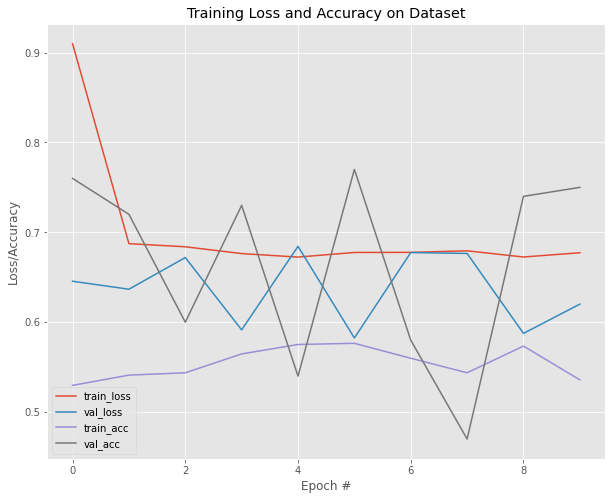

In [120]:
## plot performance history for model 1
plot_history(history)

In [121]:
## train  model2
# Todo
new_model = Sequential()
new_model.add(vgg_model)
model2 = build_my_model2(new_model)

history = model2.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)


Epoch 1/10
72/72 [==============================] - 60s 834ms/step - loss: 2.3149 - accuracy: 0.5026 - val_loss: 0.7431 - val_accuracy: 0.2000

Epoch 00001: val_loss did not improve from 0.58243
Epoch 2/10
72/72 [==============================] - 59s 814ms/step - loss: 0.7656 - accuracy: 0.5048 - val_loss: 0.6820 - val_accuracy: 0.7900

Epoch 00002: val_loss did not improve from 0.58243
Epoch 3/10
72/72 [==============================] - 59s 814ms/step - loss: 0.7206 - accuracy: 0.4908 - val_loss: 0.6915 - val_accuracy: 0.6400

Epoch 00003: val_loss did not improve from 0.58243
Epoch 4/10
72/72 [==============================] - 58s 802ms/step - loss: 0.6955 - accuracy: 0.5175 - val_loss: 0.6788 - val_accuracy: 0.8000

Epoch 00004: val_loss did not improve from 0.58243
Epoch 5/10
72/72 [==============================] - 58s 808ms/step - loss: 0.7032 - accuracy: 0.5197 - val_loss: 0.6884 - val_accuracy: 0.7100

Epoch 00005: val_loss did not improve from 0.58243
Epoch 6/10
72/72 [=======

In [122]:
history_df=pd.DataFrame(history.history)
performance.append( history_df[history_df['val_loss']==min(history_df['val_loss'])]  )
performance

[   val_loss  val_accuracy      loss  accuracy
 5  0.582433          0.77  0.677581  0.576486,
    val_loss  val_accuracy      loss  accuracy
 3  0.678846           0.8  0.695653  0.517483]

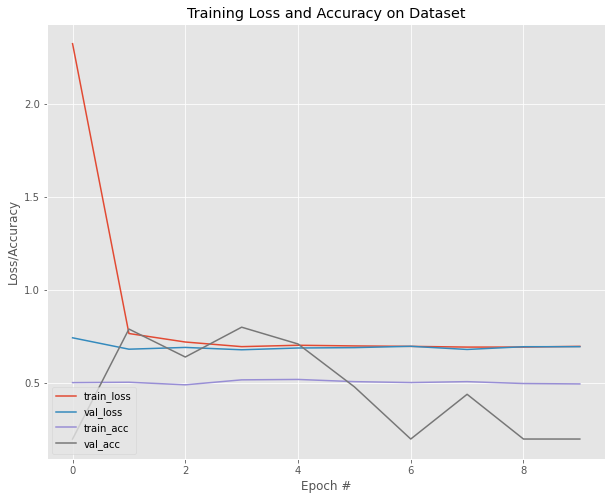

In [123]:
## plot performance history for model 2
plot_history(history)

In [124]:
## train  model3
# Todo
new_model = Sequential()
new_model.add(vgg_model)
model3 = build_my_model3(new_model)

history = model3.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
72/72 [==============================] - 60s 835ms/step - loss: 0.9935 - accuracy: 0.4899 - val_loss: 0.5982 - val_accuracy: 0.8000

Epoch 00001: val_loss did not improve from 0.58243
Epoch 2/10
72/72 [==============================] - 58s 810ms/step - loss: 0.8084 - accuracy: 0.5153 - val_loss: 0.6499 - val_accuracy: 0.8000

Epoch 00002: val_loss did not improve from 0.58243
Epoch 3/10
72/72 [==============================] - 58s 812ms/step - loss: 0.7484 - accuracy: 0.5258 - val_loss: 0.6450 - val_accuracy: 0.8000

Epoch 00003: val_loss did not improve from 0.58243
Epoch 4/10
72/72 [==============================] - 59s 820ms/step - loss: 0.7282 - accuracy: 0.5227 - val_loss: 0.6785 - val_accuracy: 0.6000

Epoch 00004: val_loss did not improve from 0.58243
Epoch 5/10
72/72 [==============================] - 58s 808ms/step - loss: 0.7267 - accuracy: 0.5157 - val_loss: 0.6559 - val_accuracy: 0.8000

Epoch 00005: val_loss did not improve from 0.58243
Epoch 6/10
72/72 [=======

In [125]:
history_df=pd.DataFrame(history.history)
performance.append( history_df[history_df['val_loss']==min(history_df['val_loss'])]  )
performance 


[   val_loss  val_accuracy      loss  accuracy
 5  0.582433          0.77  0.677581  0.576486,
    val_loss  val_accuracy      loss  accuracy
 3  0.678846           0.8  0.695653  0.517483,
    val_loss  val_accuracy      loss  accuracy
 0  0.598196           0.8  0.994921  0.489948]

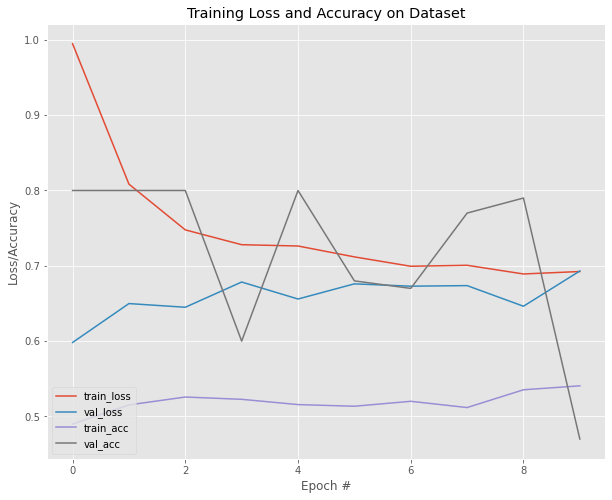

In [126]:
## plot performance history for model 3
plot_history(history)

In [127]:
## train  model4
# Todo
new_model = Sequential()
new_model.add(vgg_model)
model4 = build_my_model4(new_model)

history = model4.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
72/72 [==============================] - 59s 824ms/step - loss: 0.7350 - accuracy: 0.5459 - val_loss: 0.5971 - val_accuracy: 0.7600

Epoch 00001: val_loss did not improve from 0.58243
Epoch 2/10
72/72 [==============================] - 58s 811ms/step - loss: 0.6894 - accuracy: 0.5629 - val_loss: 0.6178 - val_accuracy: 0.8000

Epoch 00002: val_loss did not improve from 0.58243
Epoch 3/10
72/72 [==============================] - 58s 802ms/step - loss: 0.6710 - accuracy: 0.5918 - val_loss: 0.6184 - val_accuracy: 0.6900

Epoch 00003: val_loss did not improve from 0.58243
Epoch 4/10
72/72 [==============================] - 59s 821ms/step - loss: 0.6585 - accuracy: 0.5944 - val_loss: 0.7641 - val_accuracy: 0.4600

Epoch 00004: val_loss did not improve from 0.58243
Epoch 5/10
72/72 [==============================] - 59s 821ms/step - loss: 0.6635 - accuracy: 0.5931 - val_loss: 0.7491 - val_accuracy: 0.4600

Epoch 00005: val_loss did not improve from 0.58243
Epoch 6/10
72/72 [=======

In [128]:
history_df=pd.DataFrame(history.history)
performance.append( history_df[history_df['val_loss']==min(history_df['val_loss'])]  )
performance 

[   val_loss  val_accuracy      loss  accuracy
 5  0.582433          0.77  0.677581  0.576486,
    val_loss  val_accuracy      loss  accuracy
 3  0.678846           0.8  0.695653  0.517483,
    val_loss  val_accuracy      loss  accuracy
 0  0.598196           0.8  0.994921  0.489948,
    val_loss  val_accuracy      loss  accuracy
 5  0.527315          0.78  0.662401   0.60271]

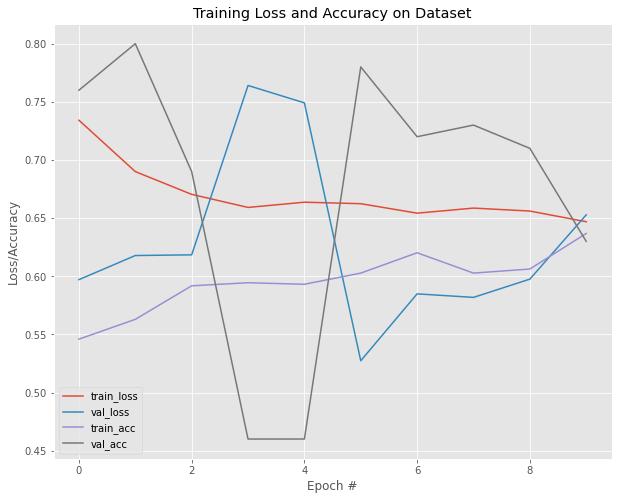

In [129]:
## plot performance history for model 4
plot_history(history)

Model 4 seems to be the best of the 4 models. Looks like a single Dense layer of 256 added and a slow learning rate of 0.0001 have the lowest validation lost. I am going to calculate the F1 score from modlel 4 results to determine the threshold for predictions. 

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [19]:
#Tai creating model to load saved weights without training
vgg_model = load_pretrained_model()
new_model = Sequential()
new_model.add(vgg_model)
build_my_model4(new_model)

553467904/553467096 [==============================] - 9s 0us/step


In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 10, verbose = True)

100/100 [==============================] - 110s 1s/step


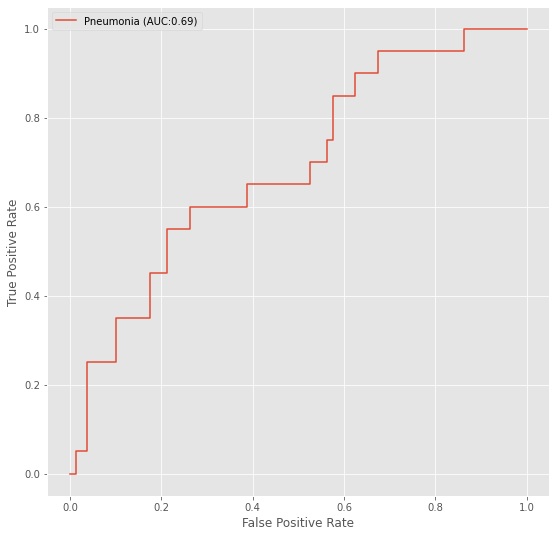

In [131]:
fpr, tpr, thresholds_ROC, AUC =  plot_roc_curve(valY, pred_Y)

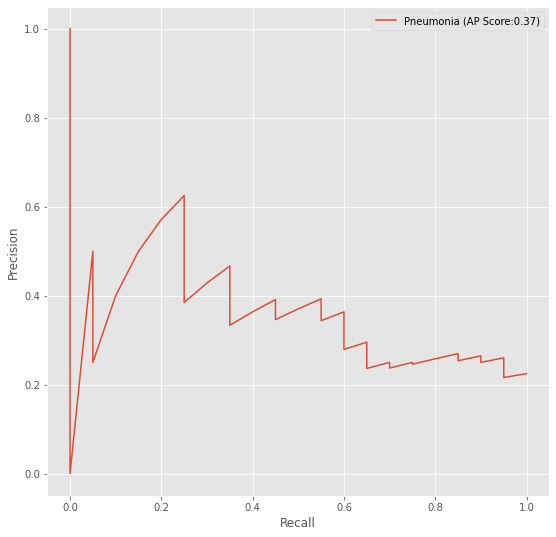

In [132]:
precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


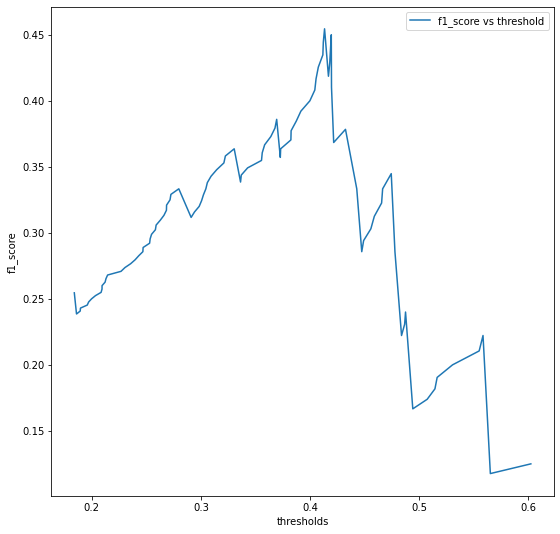

In [52]:
f1_score = plot_f1t(valY, pred_Y)

Max F1 Score: 0.45833333333333337
Threshold corresponding to max F1: 0.4456912875175476
61
Threshold is: 0.4456913


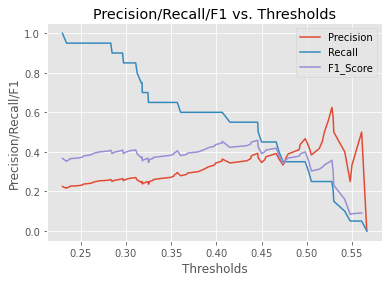

In [134]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

max_f1 = max(f1_score)
print("Max F1 Score: {}".format(max_f1))
threshold = thresholds[np.nanargmax(f1_score)]
print("Threshold corresponding to max F1: {}".format(threshold))

idx = np.nanargmin((np.abs(f1_score - max_f1)))
print(idx)
print('Threshold is: '+ str(thresholds[idx]))
      

plot_score_thresholds(precision[:-1], recall[:-1], f1_score[:-1], thresholds)

Max F1 Score: 0.4545454545454545
Threshold corresponding to max F1: 0.41326144337654114


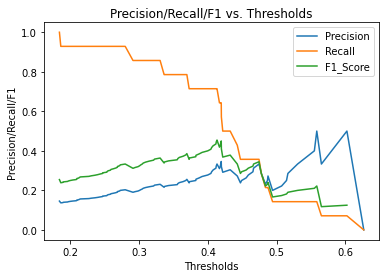

In [33]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

max_f1 = max(f1_score)
print("Max F1 Score: {}".format(max_f1))
threshold = thresholds[np.nanargmax(f1_score)]
print("Threshold corresponding to max F1: {}".format(threshold))

plot_score_thresholds(precision[:-1], recall[:-1], f1_score[:-1], thresholds)

### Final threshold for inference is 0.413 value.

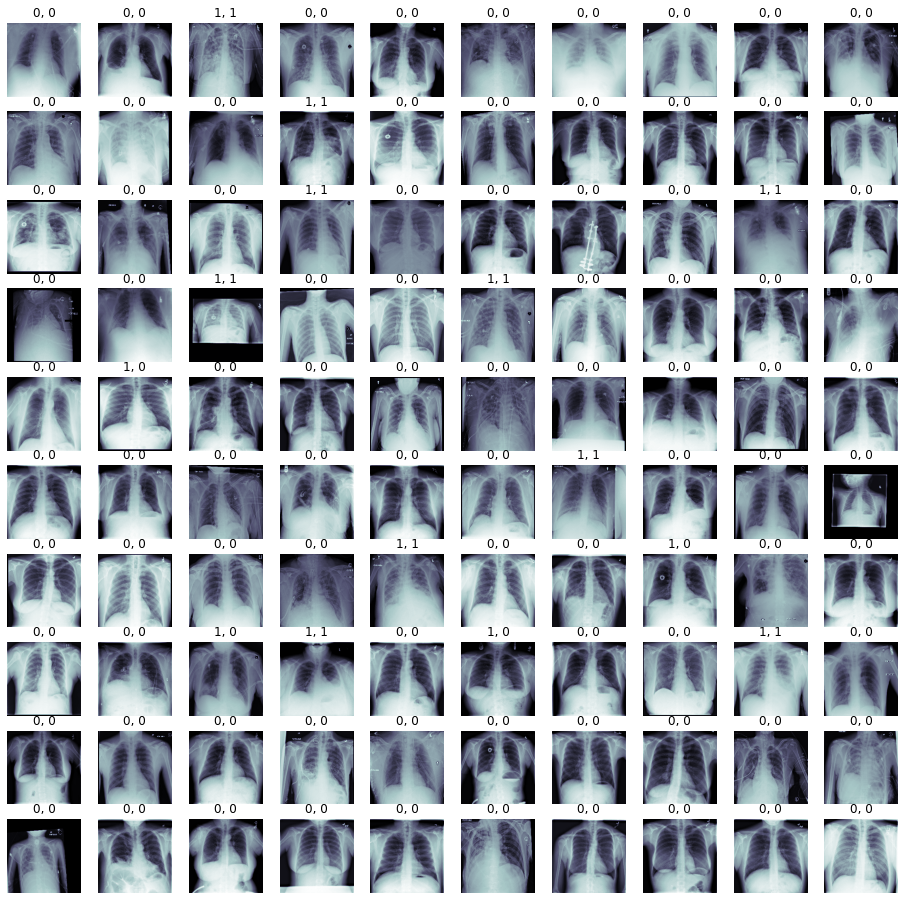

In [44]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
chosen_threshold=  0.4132614
#chosen_threshold=  0.2
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > chosen_threshold:
            c_ax.set_title('1, 1') #TP
        else:
            c_ax.set_title('1, 0')  #FN
    else:
        if pred_Y[i] > 0.7: 
            c_ax.set_title('0, 1') #FP
        else:
            c_ax.set_title('0, 0') #TN
    c_ax.axis('off')
    i=i+1

### Confusion Matrix

In [45]:

pred_Y_chosen = []
for x in range(len(pred_Y)):
    if pred_Y[x] >  chosen_threshold:
        pred_Y_chosen.append(1)
    else:
        pred_Y_chosen.append(0)

tn,fp,fn,tp =confusion_matrix(valY,pred_Y_chosen).ravel()
print (tp, fp,"\n",fn,tn)

10 20 
 4 66


In [ ]:
## Just save model architecture to a .json:
model_json = my_model4.to_json()

with open("out/my_model.json", "w") as json_file:
    json_file.write(model_json)